# DenseNet sur 5 classes

## Les imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import ReduceLROnPlateau


## Préparations des données 

In [2]:
class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.dataset[index]
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

    def __len__(self):
        return len(self.dataset)

# Transforms entraînement
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.7),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(p=0.3),
    A.GaussNoise(p=0.2),
    A.CLAHE(p=0.3),
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

# Chemins vers les dossiers (modifiés à 5 classes)
train_path = "FER_2013/train"
val_path = "FER_2013/test"

base_train_dataset = ImageFolder(train_path)
train_dataset = AlbumentationsDataset(base_train_dataset, transform=train_transforms)
val_dataset = ImageFolder(val_path, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=4)


/home/grp1issd/Desktop/Projet_TPE/env/lib/python3.12/site-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [3]:
print("Classes détectées :", base_train_dataset.classes)
print("Nombre de classes :", len(base_train_dataset.classes))

Classes détectées : ['angry', 'fear', 'happy', 'sad']
Nombre de classes : 4


In [4]:

import shutil

def clean_dataset(root_path, keep_classes):
    for split in ['train', 'test']:
        path = os.path.join(root_path, split)
        for class_dir in os.listdir(path):
            full_path = os.path.join(path, class_dir)
            if class_dir not in keep_classes and os.path.isdir(full_path):
                print(f"Suppression du dossier non désiré : {full_path}")
                shutil.rmtree(full_path)

# Utilisation
keep = ['angry', 'fear', 'happy', 'neutral', 'sad']
clean_dataset('FER_2013', keep)


## Création du modele DenseNet 121 !! 5 classes

In [5]:
def create_model(num_classes=4):
    model = models.densenet121(pretrained=True)
    for idx, block in enumerate(model.features):
        if idx <= 7:
            for param in block.parameters():
                param.requires_grad = False

    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)
    return model


## Fonctions d'entrainement / évalutation

In [6]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += images.size(0)

    return total_loss / total, correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += images.size(0)

    return total_loss / total, correct / total


## Entrainement du modèle

In [7]:
all_losses_train = []
all_losses_val = []
all_acc_train = []
all_acc_val = []


In [8]:
def train_model(model, train_loader, val_loader, num_epochs=20, save_dir="DenseNet121"):
    os.makedirs(save_dir, exist_ok=True)
    device_ = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device_)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    best_val_acc = 0.0
    best_model_wts = model.state_dict()
    log_file_path = os.path.join(save_dir, "training_log.txt")

    with open(log_file_path, "w") as log_file:
        for epoch in range(1, num_epochs + 1):
            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device_)
            val_loss, val_acc = evaluate(model, val_loader, criterion, device_)

            log = (f"Epoch {epoch:02d} | TRAIN loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
                   f"VALID loss: {val_loss:.4f}, acc: {val_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
            print(log)
            all_losses_train.append(train_loss)
            all_losses_val.append(val_loss)
            all_acc_train.append(train_acc)
            all_acc_val.append(val_acc)

            log_file.write(log + "\n")

            scheduler.step(val_loss)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_wts = model.state_dict()

    save_path = os.path.join(save_dir, f"best_densenet121_acc{best_val_acc:.4f}.pth")
    torch.save(best_model_wts, save_path)
    print(f" Meilleur modèle sauvegardé : {save_path}")
    return model


## Lancer l'entrainement 

In [10]:
if __name__ == "__main__":
    model = create_model(num_classes=4)
    trained_model = train_model(model, train_loader, val_loader, num_epochs=50)


Epoch 01 | TRAIN loss: 1.0351, acc: 0.5374 | VALID loss: 0.7624, acc: 0.6766 | LR: 1.00e-04
Epoch 02 | TRAIN loss: 0.8925, acc: 0.6125 | VALID loss: 0.7122, acc: 0.7042 | LR: 1.00e-04
Epoch 03 | TRAIN loss: 0.8463, acc: 0.6331 | VALID loss: 0.6925, acc: 0.7166 | LR: 1.00e-04
Epoch 04 | TRAIN loss: 0.8112, acc: 0.6542 | VALID loss: 0.6772, acc: 0.7244 | LR: 1.00e-04
Epoch 05 | TRAIN loss: 0.7861, acc: 0.6632 | VALID loss: 0.6674, acc: 0.7352 | LR: 1.00e-04
Epoch 06 | TRAIN loss: 0.7661, acc: 0.6811 | VALID loss: 0.6759, acc: 0.7268 | LR: 1.00e-04
Epoch 07 | TRAIN loss: 0.7483, acc: 0.6843 | VALID loss: 0.6476, acc: 0.7402 | LR: 1.00e-04
Epoch 08 | TRAIN loss: 0.7270, acc: 0.6979 | VALID loss: 0.6584, acc: 0.7344 | LR: 1.00e-04
Epoch 09 | TRAIN loss: 0.7128, acc: 0.7039 | VALID loss: 0.6691, acc: 0.7402 | LR: 1.00e-04
Epoch 10 | TRAIN loss: 0.6927, acc: 0.7127 | VALID loss: 0.6628, acc: 0.7398 | LR: 1.00e-04
Epoch 11 | TRAIN loss: 0.6834, acc: 0.7155 | VALID loss: 0.6604, acc: 0.7537 | L

## Fonction d'affichage

In [11]:
import matplotlib.pyplot as plt

def plot_metrics(train_loss, val_loss, train_acc, val_acc, save_dir):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_curves.png"))
    plt.show()


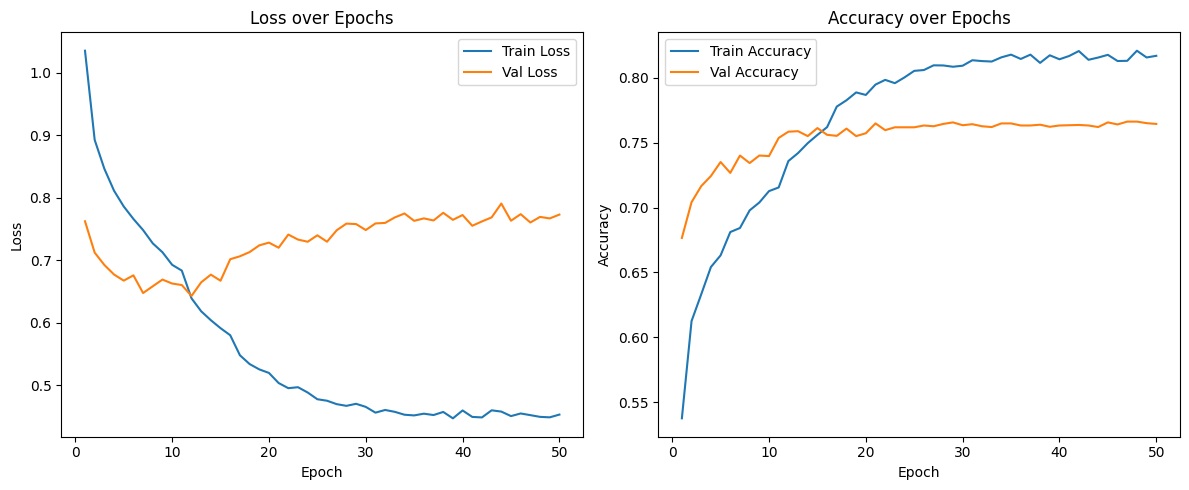

In [12]:
    # Enregistrer les courbes
save_dir = "savedir"
plot_metrics(all_losses_train, all_losses_val, all_acc_train, all_acc_val, save_dir)


In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def test_model(model, test_loader, device, class_names):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("📊 Rapport de classification :\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print(" Matrice de confusion :\n")
    print(confusion_matrix(all_labels, all_preds))


In [14]:
# Supposons que les noms des classes sont :
class_names = ['angry', 'fear', 'happy', 'neutral', 'sad']
val_loader_for_test = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_model(trained_model, val_loader_for_test, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), class_names=class_names)


📊 Rapport de classification :

              precision    recall  f1-score   support

       angry       0.67      0.65      0.66       958
        fear       0.68      0.56      0.61      1024
       happy       0.91      0.91      0.91      1774
     neutral       0.66      0.69      0.68      1233
         sad       0.57      0.64      0.61      1247

    accuracy                           0.72      6236
   macro avg       0.70      0.69      0.69      6236
weighted avg       0.72      0.72      0.72      6236

📌 Matrice de confusion :

[[ 627   91   29   70  141]
 [ 116  571   25   87  225]
 [  23   24 1609   83   35]
 [  59   51   68  856  199]
 [ 115   97   33  198  804]]
